**13. DATA AUGMENTATION**

1st way of data augmentation

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds


In [8]:
(ds_train, ds_test), ds_info = tfds.load(
    "cifar10",
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=True,  # will return tuple (img, label) otherwise dict
    with_info=True,  # able to get info about dataset
)

In [9]:
def normalize_img(image, label):
    """Normalizes images"""
    return tf.cast(image, tf.float32) / 255.0, label

The tf.cast() function in TensorFlow is used to cast a tensor to a new data type. In this context, it's being used to convert the image tensor from its original data type to tf.float32, which is a common data type used for representing pixel values in image processing tasks.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32

In [11]:
def augment(image, label):
    new_height = new_width = 32
    image = tf.image.resize(image, (new_height, new_width))

    if tf.random.uniform((), minval=0, maxval=1) < 0.1:
        image = tf.tile(tf.image.rgb_to_grayscale(image), [1, 1, 3])

    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.1, upper=0.2)

    # a left upside down flipped is still a dog ;)
    image = tf.image.random_flip_left_right(image)  # 50%
    # image = tf.image.random_flip_up_down(image) #%50%

    return image, label

In [12]:
# Setup for train dataset
ds_train = ds_train.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits["train"].num_examples)
ds_train = ds_train.map(augment)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(AUTOTUNE)

In [13]:
# Setup for test Dataset
ds_test = ds_train.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_test = ds_train.batch(BATCH_SIZE)
ds_test = ds_train.prefetch(AUTOTUNE)

In [14]:
# this is 2nd way of data augmentation, we will see it in the next code
# # TF >= 2.3.0
# data_augmentation = keras.Sequential(
#     [
#         layers.experimental.preprocessing.Resizing(height=32, width=32,),
#         layers.experimental.preprocessing.RandomFlip(mode="horizontal"),
#         layers.experimental.preprocessing.RandomContrast(factor=0.1,),
#     ]
# )

In [15]:
model = keras.Sequential(
    [
        keras.Input((32, 32, 3)),
        data_augmentation,
        layers.Conv2D(4, 3, padding="same", activation="relu"),
        layers.Conv2D(8, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(16, 3, padding="same", activation="relu"),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dense(10),
    ]
)

In [16]:
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [17]:
model.fit(ds_train, epochs=5, verbose=2)

Epoch 1/5
1563/1563 - 84s - loss: 2.1393 - accuracy: 0.1916 - 84s/epoch - 54ms/step
Epoch 2/5
1563/1563 - 70s - loss: 1.9779 - accuracy: 0.2756 - 70s/epoch - 45ms/step
Epoch 3/5
1563/1563 - 72s - loss: 1.9069 - accuracy: 0.3075 - 72s/epoch - 46ms/step
Epoch 4/5
1563/1563 - 65s - loss: 1.8653 - accuracy: 0.3297 - 65s/epoch - 42ms/step
Epoch 5/5
1563/1563 - 58s - loss: 1.8297 - accuracy: 0.3428 - 58s/epoch - 37ms/step


In [18]:
model.evaluate(ds_test)

1563/1563 [==============================] - 31s 20ms/step - loss: 1.8178 - accuracy: 0.3458


[1.8178290128707886, 0.3458400070667267]

**2nd way of augmentation, for tensorflow version >= 2.3.0**

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

(ds_train, ds_test), ds_info = tfds.load(
    "cifar10",
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=True,  # will return tuple (img, label) otherwise dict
    with_info=True,  # able to get info about dataset
)


def normalize_img(image, label):
    """Normalizes images"""
    return tf.cast(image, tf.float32) / 255.0, label


AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32


# Setup for train dataset
ds_train = ds_train.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits["train"].num_examples)
# ds_train = ds_train.map(augment) # it was 1st way of data augmentation, we have done it.
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(AUTOTUNE)

# Setup for test Dataset
ds_test = ds_train.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_test = ds_train.batch(BATCH_SIZE)
ds_test = ds_train.prefetch(AUTOTUNE)

# TF >= 2.3.0
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Resizing(height=32, width=32,),
        layers.experimental.preprocessing.RandomFlip(mode="horizontal"),
        layers.experimental.preprocessing.RandomContrast(factor=0.1,),
    ]
)

model = keras.Sequential(
    [
        keras.Input((32, 32, 3)),
        data_augmentation,
        layers.Conv2D(4, 3, padding="same", activation="relu"),
        layers.Conv2D(8, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(16, 3, padding="same", activation="relu"),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dense(10),
    ]
)

model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

model.fit(ds_train, epochs=5, verbose=2)
model.evaluate(ds_test)

Epoch 1/5
1563/1563 - 66s - loss: 1.7323 - accuracy: 0.3807 - 66s/epoch - 42ms/step
Epoch 2/5
1563/1563 - 56s - loss: 1.3988 - accuracy: 0.5051 - 56s/epoch - 36ms/step
Epoch 3/5
1563/1563 - 62s - loss: 1.2887 - accuracy: 0.5422 - 62s/epoch - 39ms/step
Epoch 4/5
1563/1563 - 63s - loss: 1.2218 - accuracy: 0.5699 - 63s/epoch - 40ms/step
Epoch 5/5
1563/1563 - 58s - loss: 1.1687 - accuracy: 0.5880 - 58s/epoch - 37ms/step
1563/1563 [==============================] - 24s 15ms/step - loss: 1.1742 - accuracy: 0.5873


[1.1741719245910645, 0.5873399972915649]

Data augmentation, helps in reducing the overfitting.

Let's understand the first data augmentation code, 2nd vala toh simple hai.

```
def augment(image, label):
    new_height = new_width = 32
    image = tf.image.resize(image, (new_height, new_width))

    if tf.random.uniform((), minval=0, maxval=1) < 0.1:
        image = tf.tile(tf.image.rgb_to_grayscale(image), [1, 1, 3])

    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.1, upper=0.2)

    # a left upside down flipped is still a dog ;)
    image = tf.image.random_flip_left_right(image)  # 50%
    # image = tf.image.random_flip_up_down(image) #%50%

    return image, label
```
```
ds_train = ds_train.map(augment)
```


This data augmentation function, `augment(image, label)`, is designed to perform various transformations on input images to enhance the diversity and robustness of the training data. Let's dissect the function with the help of the provided lecture transcript:

1. **Resize Image**:
   ```python
   new_height = new_width = 32
   image = tf.image.resize(image, (new_height, new_width))
   ```
   - If necessary, resize the image to a target size of 32x32 pixels using `tf.image.resize()`.

2. **Convert to Grayscale (with Probability)**:
   ```python
   if tf.random.uniform((), minval=0, maxval=1) < 0.1:
       image = tf.tile(tf.image.rgb_to_grayscale(image), [1, 1, 3])
   ```
   - With a probability of 0.1 (10% of the time), convert the image to grayscale using `tf.image.rgb_to_grayscale()`.
   - Since the grayscale image will have only one channel, `tf.tile()` is used to replicate the single channel across three channels, making it compatible with models expecting RGB inputs.

3. **Random Brightness Adjustment**:
   ```python
   image = tf.image.random_brightness(image, max_delta=0.1)
   ```
   - Randomly adjust the brightness of the image using `tf.image.random_brightness()`.
   - `max_delta=0.1` specifies the maximum amount by which pixel values can be adjusted.

4. **Random Contrast Adjustment**:
   ```python
   image = tf.image.random_contrast(image, lower=0.1, upper=0.2)
   ```
   - Randomly adjust the contrast of the image using `tf.image.random_contrast()`.
   - `lower=0.1` and `upper=0.2` specify the range within which the contrast can be adjusted.

5. **Random Horizontal Flip**:
   ```python
   image = tf.image.random_flip_left_right(image)  # 50%
   ```
   - Randomly flip the image horizontally with a 50% probability using `tf.image.random_flip_left_right()`.

6. **Return Augmented Image and Label**:
   ```python
   return image, label
   ```
   - Return the augmented image along with the original label.

By applying these transformations with certain probabilities, the function introduces variability into the training data, helping the model generalize better to unseen examples. **It's important to note that these augmentations are performed in real-time during model training, effectively increasing the effective size of the training dataset without actually expanding it.**

**Without expanding the actual size of training dataset, augmentation is done, and it feels like the effective size of training dataset is increased, but this is not the case : "While the GPU is training the current batch of data, the CPU is simultaneously fetching the next batch and performing data augmentation on those images."**

The speaker is emphasizing that data augmentation is not merely about increasing the quantity of data samples in a dataset. Instead, it's about enhancing the diversity and quality of the training data to improve the model's generalization performance.

Here's a breakdown of the main points conveyed by the speaker:

1. **Misconception about Data Augmentation**:
   - Many people mistakenly believe that data augmentation directly increases the size of the dataset. For example, if you have 100 images and apply data augmentation, you might think you'll end up with 300 images. However, this is not entirely accurate.

2. **Real-time Data Augmentation**:
   - The speaker clarifies that data augmentation is typically performed on-the-fly during model training.
   - While the GPU is training the current batch of data, the CPU is simultaneously fetching the next batch and performing data augmentation on those images.
   - This real-time augmentation effectively makes the dataset larger without actually increasing its size on disk.

3. **Effectiveness of Data Augmentation**:
   - The speaker raises a thought-provoking question about the effective dataset size after introducing data augmentation.
   - It's challenging to quantify the effective dataset size precisely because data augmentation introduces randomness and variability into each image.
   - For example, even a slight change in brightness or color can theoretically produce an infinite number of variations for each image.

4. **Sequential Augmentation Process**:
   - The speaker explains that data augmentation operations are performed sequentially on each image in the dataset.
   - In the provided example, resizing, converting to grayscale, adjusting brightness, etc., are performed in a specific order.
   - Additionally, the speaker encourages exploring the extensive documentation on data augmentation techniques, which offer numerous possibilities for customizing augmentation operations.

In essence, the speaker underscores that data augmentation is a sophisticated process aimed at enriching the training data with diverse variations, rather than simply inflating the dataset size. It's about improving the quality and robustness of the dataset to enhance the model's ability to generalize to unseen examples.

**TF >= 2.3.0
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Resizing(height=32, width=32,),
        layers.experimental.preprocessing.RandomFlip(mode="horizontal"),
        layers.experimental.preprocessing.RandomContrast(factor=0.1,),
    ]
)
The orator next gives another way of data augmentaion, What is different in it and which one is better????**

The speaker introduces an alternative approach to data augmentation using the `layers.experimental.preprocessing` module available in TensorFlow 2.3.0 and later versions. Let's compare this approach with the previously discussed custom augmentation function:

### Approach 1: Custom Augmentation Function
- **Customized Operations**: The custom augmentation function allows for more flexibility in defining specific augmentation operations, such as resizing, grayscale conversion, brightness adjustment, etc.
- **Control over Operations**: Each augmentation operation can be customized individually, including the probability of applying each operation and the range of parameters (e.g., brightness delta).
- **Sequential Execution**: Operations are executed sequentially in the defined order.
- **Complexity**: The custom function may require more lines of code and manual adjustment of parameters.

### Approach 2: Sequential Model with Preprocessing Layers
- **Layer-Based Approach**: Data augmentation operations are defined using prebuilt preprocessing layers provided by TensorFlow, such as `Resizing`, `RandomFlip`, `RandomContrast`, etc.
- **Simplicity**: The sequential model with preprocessing layers offers a more straightforward and concise way to define data augmentation pipelines without manually coding each operation.
- **Integration with Keras Models**: It seamlessly integrates with Keras models, making it easier to incorporate data augmentation into the model architecture.
- **Reusability**: The predefined preprocessing layers can be reused across different models or experiments with minimal effort.
- **Standardization**: The predefined layers follow standard conventions and are optimized for performance and compatibility with TensorFlow's APIs.

### Comparison:
- **Flexibility vs. Convenience**: The custom augmentation function provides more flexibility and control over augmentation operations, allowing for fine-tuning of parameters. On the other hand, the sequential model with preprocessing layers offers convenience and ease of use by providing prebuilt layers for common augmentation tasks.
- **Complexity vs. Simplicity**: The custom function may be more complex due to manual coding and parameter tuning, while the preprocessing layers offer simplicity and abstraction, making it easier to define augmentation pipelines.

### Conclusion:
The choice between these approaches depends on factors such as the specific requirements of the task, the desired level of customization, and the trade-off between flexibility and simplicity. Both approaches are valid and effective, and the decision should be based on the particular needs and preferences of the user.

In summary : **Custom augmentation = flexibility more but complexity more.**

**predefined layers = simplicity more but less flexible**

#**14. Callbacks with keras:**
**callbacks are a way to customize the behaviour of your model during either training or evaluation.**


REMEMBER THERE ARE SO MANY CALLBACK OPTIONS ARE AVAILABLE IN KERAS, LIKE:

Keras provides a wide range of callbacks to customize and enhance the training process. Here are some commonly used callbacks along with their functionalities:

1. **ModelCheckpoint**: Saves the model's weights during training at specified intervals or when a monitored metric improves.

2. **EarlyStopping**: Stops training when a monitored metric has stopped improving, thus preventing overfitting.

3. **ReduceLROnPlateau**: Reduces the learning rate when a monitored metric has stopped improving, helping to reach a minimum more accurately.

4. **TensorBoard**: Logs training metrics and visualizes them in TensorBoard for easy monitoring and analysis.

5. **CSVLogger**: Streams training results to a CSV file, allowing for easy tracking of metrics over time.

6. **LearningRateScheduler**: Dynamically adjusts the learning rate during training based on a predefined schedule.

7. **TerminateOnNaN**: Terminates training if a NaN (Not a Number) loss is encountered, preventing further model updates.

8. **RemoteMonitor**: Sends training metrics to a remote server for monitoring and analysis.

9. **LambdaCallback**: Allows for custom callbacks by defining a function to be called at specific points during training.

10. **ModelCheckpointEveryEpoch**: A custom callback that saves the model's weights after every epoch, useful for additional checkpoints.

11. **CustomCallback**: Enables the creation of custom callbacks tailored to specific requirements or research purposes.

These are just a few examples of the many callbacks available in Keras. Each callback serves a specific purpose and can be combined or customized to meet the needs of your training process.

In [21]:
import matplotlib.pyplot

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds


(ds_train, ds_test), ds_info = tfds.load(
    "mnist",
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=True,  # will return tuple (img, label) otherwise dict
    with_info=True,  # able to get info about dataset
)


def normalize_img(image, label):
    """Normalizes images"""
    return tf.cast(image, tf.float32) / 255.0, label


AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 128

# Setup for train dataset
ds_train = ds_train.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits["train"].num_examples)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(AUTOTUNE)

model = keras.Sequential(
    [
        keras.Input((28, 28, 1)),
        layers.Conv2D(32, 3, activation="relu"),
        layers.Flatten(),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)

save_callback = keras.callbacks.ModelCheckpoint(
    "checkpoint/", save_weights_only=True, monitor="train_acc", save_best_only=False,
)

model.compile(
    optimizer=keras.optimizers.Adam(0.01),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

model.fit(
    ds_train,
    epochs=10,
    callbacks=[save_callback],
    verbose=2,
)

Epoch 1/10
469/469 - 24s - loss: 0.1518 - accuracy: 0.9544 - 24s/epoch - 52ms/step
Epoch 2/10
469/469 - 16s - loss: 0.0612 - accuracy: 0.9804 - 16s/epoch - 34ms/step
Epoch 3/10
469/469 - 17s - loss: 0.0366 - accuracy: 0.9886 - 17s/epoch - 37ms/step
Epoch 4/10
469/469 - 17s - loss: 0.0275 - accuracy: 0.9905 - 17s/epoch - 37ms/step
Epoch 5/10
469/469 - 17s - loss: 0.0199 - accuracy: 0.9934 - 17s/epoch - 35ms/step
Epoch 6/10
469/469 - 17s - loss: 0.0173 - accuracy: 0.9939 - 17s/epoch - 35ms/step
Epoch 7/10
469/469 - 18s - loss: 0.0149 - accuracy: 0.9951 - 18s/epoch - 39ms/step
Epoch 8/10
469/469 - 17s - loss: 0.0152 - accuracy: 0.9948 - 17s/epoch - 37ms/step
Epoch 9/10
469/469 - 17s - loss: 0.0137 - accuracy: 0.9954 - 17s/epoch - 36ms/step
Epoch 10/10
469/469 - 18s - loss: 0.0127 - accuracy: 0.9960 - 18s/epoch - 39ms/step


In [23]:
import matplotlib.pyplot
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

(ds_train, ds_test), ds_info = tfds.load(
    "mnist",
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=True,  # will return tuple (img, label) otherwise dict
    with_info=True,  # able to get info about dataset
)


def normalize_img(image, label):
    """Normalizes images"""
    return tf.cast(image, tf.float32) / 255.0, label


AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 128

# Setup for train dataset
ds_train = ds_train.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits["train"].num_examples)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(AUTOTUNE)

model = keras.Sequential(
    [
        keras.Input((28, 28, 1)),
        layers.Conv2D(32, 3, activation="relu"),
        layers.Flatten(),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)

# 1st callback
save_callback = keras.callbacks.ModelCheckpoint(
    "checkpoint/", save_weights_only=True, monitor="train_acc", save_best_only=False,
)

# 2nd callback, upar vale code me keval 1 call back tha
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor="loss", factor=0.1, patience=3, mode="max", verbose=1
)

model.compile(
    optimizer=keras.optimizers.Adam(0.01),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

model.fit(
    ds_train,
    epochs=2,
    callbacks=[save_callback, lr_scheduler], # callback list
    verbose=2,
)

Epoch 1/2
469/469 - 25s - loss: 0.1466 - accuracy: 0.9568 - lr: 0.0100 - 25s/epoch - 53ms/step
Epoch 2/2
469/469 - 17s - loss: 0.0571 - accuracy: 0.9825 - lr: 0.0100 - 17s/epoch - 36ms/step


Here one more call back is used wrt to the first code:

The second callback used in the provided code is `ReduceLROnPlateau`. Let's understand what this callback does and its significance in the training process:

### `ReduceLROnPlateau` Callback:
- **Functionality**: This callback monitors a specified metric during training (in this case, it's monitoring the loss), and it reduces the learning rate (LR) when the monitored metric has stopped improving.
- **Parameters**:
  - **`monitor`**: The metric to be monitored. In this case, it's set to `"loss"`, indicating that the loss will be monitored.
  - **`factor`**: The factor by which the learning rate will be reduced. If set to 0.1, it means the LR will be multiplied by 0.1 (i.e., reduced to 10% of its current value).
  - **`patience`**: Number of epochs with no improvement after which the learning rate will be reduced. If set to 3, it means the LR will be reduced after 3 epochs of no improvement.
  - **`mode`**: Specifies whether to reduce the LR when the monitored metric has stopped improving (`"max"`) or decreasing (`"min"`).
  - **`verbose`**: Controls the verbosity of the callback's output.

### Significance:
- **Learning Rate Adjustment**: This callback helps in dynamically adjusting the learning rate during training, ensuring that the model converges more effectively. It prevents overshooting the minimum and helps to fine-tune the learning process.
- **Adaptability**: By reducing the learning rate when the loss plateaus, the model becomes more adaptable to changes in the training dynamics, potentially leading to better generalization and performance on unseen data.
- **Improved Training**: With a dynamically adjusted learning rate, the model can navigate the loss landscape more efficiently, potentially leading to faster convergence and improved training results.

In summary, the `ReduceLROnPlateau` callback is used to dynamically adjust the learning rate during training based on the behavior of the loss metric, thereby enhancing the training process and improving the model's performance.

In [3]:
import matplotlib.pyplot

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

(ds_train, ds_test), ds_info = tfds.load(
    "mnist",
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=True,  # will return tuple (img, label) otherwise dict
    with_info=True,  # able to get info about dataset
)


def normalize_img(image, label):
    """Normalizes images"""
    return tf.cast(image, tf.float32) / 255.0, label


AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 128

# Setup for train dataset
ds_train = ds_train.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits["train"].num_examples)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(AUTOTUNE)

model = keras.Sequential(
    [
        keras.Input((28, 28, 1)),
        layers.Conv2D(32, 3, activation="relu"),
        layers.Flatten(),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)

# 1st callback
save_callback = keras.callbacks.ModelCheckpoint(
    "checkpoint/", save_weights_only=True, monitor="train_acc", save_best_only=False,
)

# 2nd callback
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor="loss", factor=0.1, patience=3, mode="max", verbose=1
)

# 3rd callback : new callback
class OurOwnCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get("accuracy") > 0.98:
            print("Accuracy over 90%, quitting training")
            self.model.stop_training = True


model.compile(
    optimizer=keras.optimizers.Adam(0.01),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

model.fit(
    ds_train,
    epochs=4,
    callbacks=[save_callback, lr_scheduler, OurOwnCallback()],
    verbose=2,
)

Epoch 1/4
469/469 - 20s - loss: 0.1510 - accuracy: 0.9543 - lr: 0.0100 - 20s/epoch - 43ms/step
Epoch 2/4
Accuracy over 90%, quitting training
469/469 - 16s - loss: 0.0628 - accuracy: 0.9805 - lr: 0.0100 - 16s/epoch - 34ms/step


**3rd Callback:**

The purpose of the third callback, `OurOwnCallback`, is to implement a custom stopping criterion based on a certain condition. Let's break down how this callback works and its purpose:

### `OurOwnCallback` Callback:
- **Functionality**: This callback extends the functionality of Keras by allowing users to define custom behaviors at specific points during training. In this case, it is defined to trigger an action when a certain condition is met.
- **`on_epoch_end` Method**: This method is part of the Keras callback API and is called at the end of each epoch during training.
- **Condition**: The callback checks if the accuracy metric, obtained from the training logs, exceeds a threshold value of 0.98. If the condition is met, it prints a message and stops the training process by setting `self.model.stop_training` to `True`.

### Purpose:
- **Custom Stopping Criterion**: This callback allows for the implementation of a custom stopping criterion based on any metric or condition of interest. In this case, the criterion is to stop training if the accuracy exceeds 98%. However, this can be modified to any desired condition, such as reaching a certain accuracy threshold, loss value, or any other relevant metric.

### Significance:
- **Flexibility**: Custom callbacks provide flexibility to tailor the training process according to specific requirements or criteria defined by the user.
- **Early Stopping**: By defining custom stopping conditions, users can implement early stopping strategies based on their domain knowledge or experimental observations.
- **Diagnostic Information**: Callbacks can also be used to print diagnostic information or perform additional actions during training, aiding in the monitoring and debugging of the training process.

In summary, the `OurOwnCallback` callback allows for the implementation of a custom stopping criterion during training, enabling users to define and enforce specific conditions for terminating the training process.

We have just used one function from the list given below

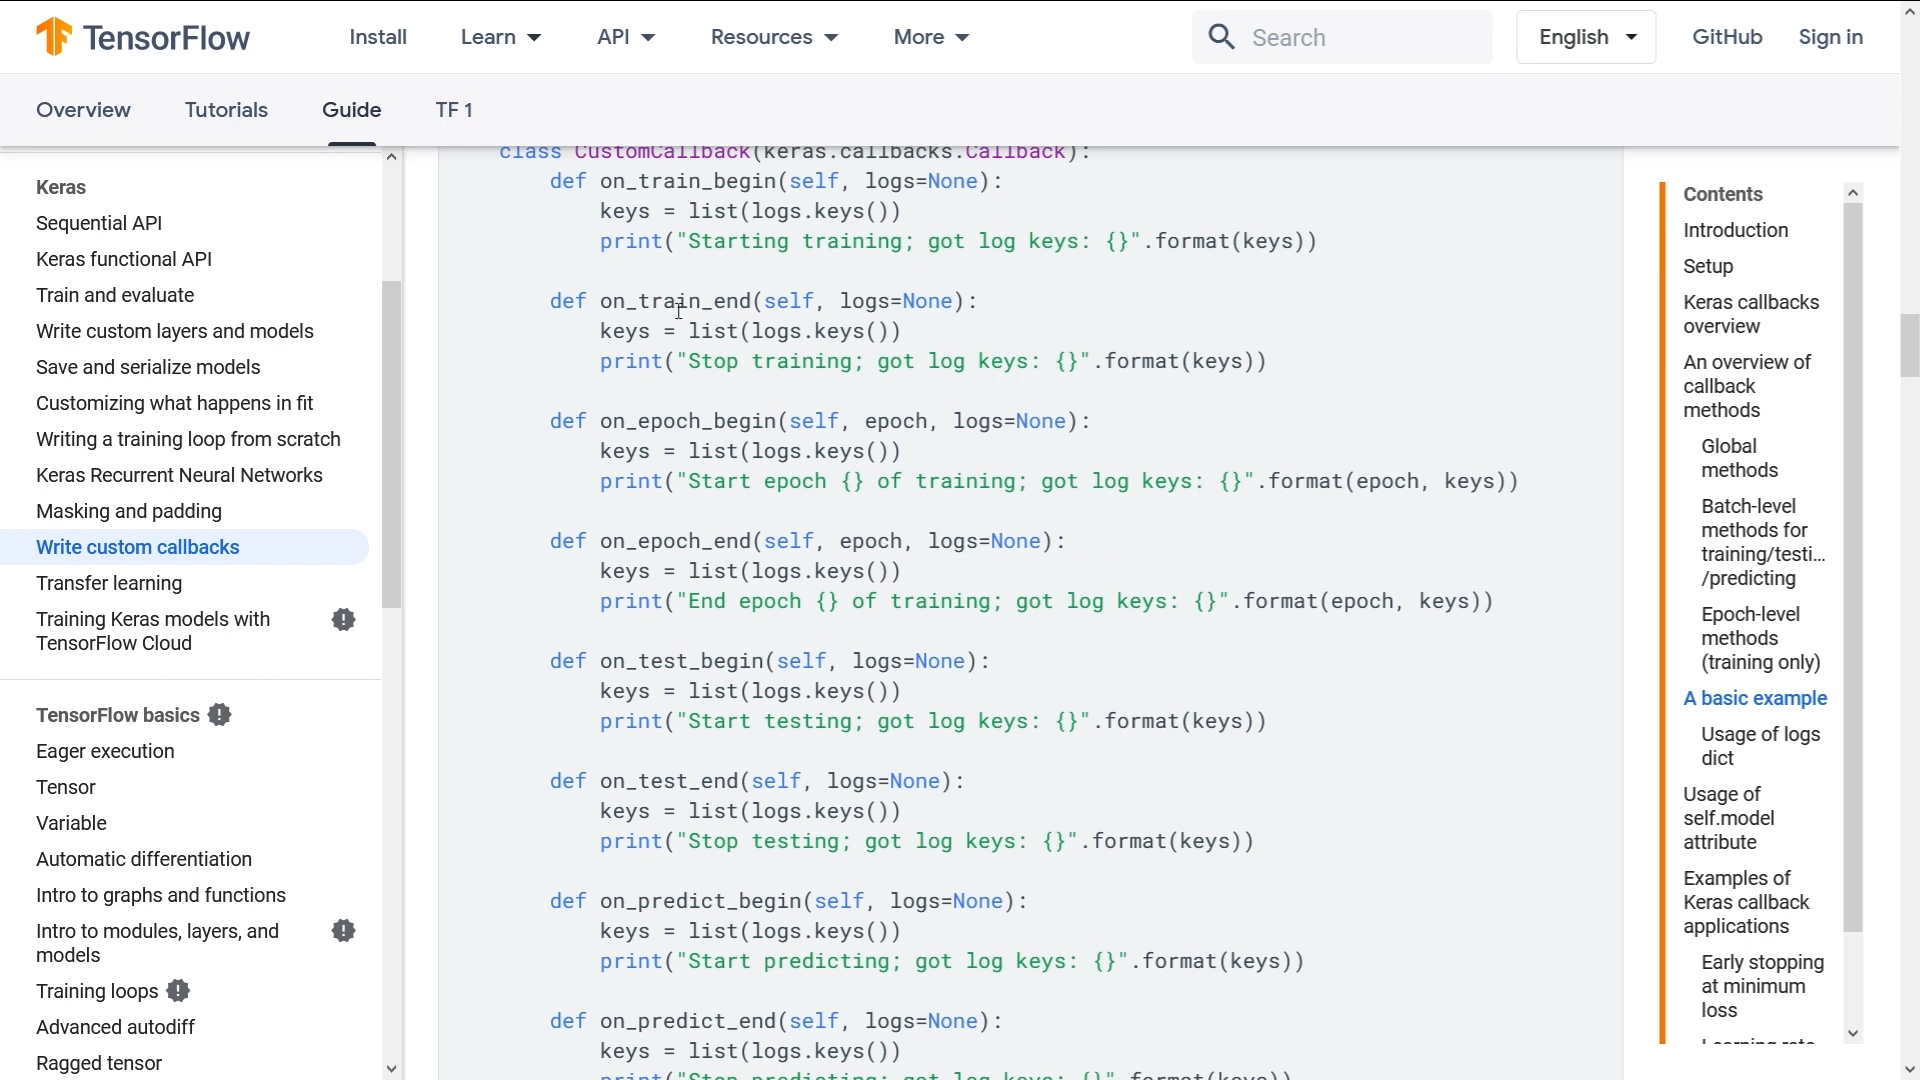

#Building more flexible(custom) training loops from scratch

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

In [6]:
(x_train, y_train),(x_test, y_test) = mnist.load_data() # this dataset is being loaded from keras, not directly from tensorflow, hence it is train and test separated

11490434/11490434 [==============================] - 0s 0us/step


In [7]:
x_train  = x_train.reshape(-1,28,28,1).astype("float32")/255.0
x_test = x_test.reshape(-1,28,28,1).astype("float32")/255.0

In [8]:
model = keras.Sequential(
    [
        layers.Input(shape=(28,28,1)),
        layers.Conv2D(64,3,padding='same'),
        layers.ReLU(),
        layers.Conv2D(128,3,padding='same'),
        layers.ReLU(),
        layers.Flatten(),
        layers.Dense(10)
    ],
    name = 'model'
)

In [22]:
class CustomFit(keras.Model): # we gonna inherit it from keras.model
  def __init__(self,model):
    super(CustomFit, self).__init__()
    self.model = model

  def train_step(self, data):
    x, y = data

    # forward propagation
    with tf.GradientTape() as tape:
      y_pred = self.model(x, training=True)
      loss = self.compiled_loss(y, y_pred)

    training_vars = self.trainable_variables
    gradients = tape.gradient(loss, training_vars)

    self.optimizer.apply_gradients(zip(gradients, training_vars))
    self.compiled_metrics.update_state(y, y_pred)

    return {m.name:m.result() for m in self.metrics}


In [23]:
training = CustomFit(model)

In [24]:
training.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [25]:
training.fit(x_train, y_train, batch_size=32, epochs=2)

Epoch 1/2
1875/1875 [==============================] - 521s 277ms/step - loss: 0.1088 - accuracy: 0.9670
Epoch 2/2
1875/1875 [==============================] - 510s 272ms/step - loss: 0.0407 - accuracy: 0.9870


Sure, let's break down the customFit() class code line by line along with explanations:

```python
class CustomFit(keras.Model):
```
- **Line 1**: Defines a new class named `CustomFit` that inherits from `keras.Model`.
  
```python
  def __init__(self,model):
    super(CustomFit, self).__init__()
    self.model = model
```
- **Lines 3-5**: Defines the constructor `__init__` method for the `CustomFit` class.
  - `self.model = model`: Assigns the input `model` to the class attribute `self.model`.

```python
  def train_step(self, data):
```
- **Line 7**: Defines a method named `train_step` within the `CustomFit` class.
  
```python
    x, y = data
```
- **Line 8**: Unpacks the input `data` into features `x` and labels `y`.

```python
    # forward propagation
    with tf.GradientTape() as tape:
      y_pred = self.model(x, training=True)
      loss = self.compiled_loss(y, y_pred)
```
- **Lines 10-12**: Initiates a gradient tape to track operations for automatic differentiation.
  - `y_pred = self.model(x, training=True)`: Performs forward propagation to obtain model predictions.
  - `loss = self.compiled_loss(y, y_pred)`: Computes the loss using the compiled loss function.

```python
    training_vars = self.trainable_variables
    gradients = tape.gradient(loss, training_vars)

    self.optimizer.apply_gradients(zip(gradients, training_vars))
    self.compiled_metrics.update_state(y, y_pred)
```
- **Lines 14-16**: Compute gradients of the loss with respect to the trainable variables.
  - `self.optimizer.apply_gradients(zip(gradients, training_vars))`: Applies gradients to update model parameters using the optimizer.
  - `self.compiled_metrics.update_state(y, y_pred)`: Updates the state of compiled metrics based on true labels and predictions.

```python
    return {m.name:m.result() for m in self.metrics}
```
- **Line 18**: Returns a dictionary containing the names and results of the metrics computed during the training step.

```python
training = CustomFit(model)
```
- **Line 21**: Creates an instance `training` of the `CustomFit` class, passing the `model` to be trained as an argument.

```python
training.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)
```
- **Lines 24-28**: Compiles the `training` instance with optimizer, loss function, and metrics for training.

```python
training.fit(x_train, y_train, batch_size=32, epochs=2)
```
- **Line 30**: Initiates the training process by calling the `fit` method on the `training` instance, passing training data (`x_train`, `y_train`), batch size, and number of epochs.

### Summary:
The code defines a custom training loop using a class `CustomFit`, which inherits from `keras.Model`. The `train_step` method within the class defines the custom training logic, including forward propagation, loss computation, gradient calculation, optimization, and metric update. Finally, an instance of `CustomFit` is created, compiled with optimizer, loss, and metrics, and then trained on the provided data using the `fit` method. This approach offers flexibility in defining custom training procedures while leveraging the functionalities provided by the Keras API.

**Now compile bhi custome**

In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1).astype("float32") / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype("float32") / 255.0

model = keras.Sequential(
    [
        layers.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, (3, 3), padding="same"),
        layers.ReLU(),
        layers.Conv2D(128, (3, 3), padding="same"),
        layers.ReLU(),
        layers.Flatten(),
        layers.Dense(10),
    ],
    name="model",
)


class CustomFit(keras.Model):
    def __init__(self, model):
        super(CustomFit, self).__init__()
        self.model = model

    def compile(self, optimizer, loss):
        super(CustomFit, self).compile()
        self.optimizer = optimizer
        self.loss = loss

    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            # Caclulate predictions
            y_pred = self.model(x, training=True)

            # Loss
            loss = self.loss(y, y_pred)

        # Gradients
        training_vars = self.trainable_variables
        gradients = tape.gradient(loss, training_vars)

        # Step with optimizer
        self.optimizer.apply_gradients(zip(gradients, training_vars))
        acc_metric.update_state(y, y_pred)

        return {"loss": loss, "accuracy": acc_metric.result()}

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_pred = self.model(x, training=False)

        # Updates the metrics tracking the loss
        loss = self.loss(y, y_pred)

        # Update the metrics.
        acc_metric.update_state(y, y_pred)
        return {"loss": loss, "accuracy": acc_metric.result()}

# without this we will not be able to track accuracy. So it is needed in custome compile case.(custome fit me accuracy mil jati hai, pr custome compile me nhi)
acc_metric = keras.metrics.SparseCategoricalAccuracy(name="accuracy")

training = CustomFit(model)
training.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)

training.fit(x_train, y_train, batch_size=64, epochs=2)
training.evaluate(x_test, y_test, batch_size=64)

Epoch 1/2
938/938 [==============================] - 521s 554ms/step - loss: 0.1735 - accuracy: 0.8888
Epoch 2/2
157/157 [==============================] - 33s 208ms/step - loss: 0.0448 - accuracy: 0.9660


[0.9668615460395813, 0.0010118114296346903]

Creating our own training and testing steps : overwritten the compile of keras, to build more flexible and complex models.

```
class CustomFit(keras.Model):
    def __init__(self, model):
        super(CustomFit, self).__init__()
        self.model = model

    def compile(self, optimizer, loss):
        super(CustomFit, self).compile()
        self.optimizer = optimizer
        self.loss = loss

    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            # Caclulate predictions
            y_pred = self.model(x, training=True)

            # Loss
            loss = self.loss(y, y_pred)

        # Gradients
        training_vars = self.trainable_variables
        gradients = tape.gradient(loss, training_vars)

        # Step with optimizer
        self.optimizer.apply_gradients(zip(gradients, training_vars))
        acc_metric.update_state(y, y_pred)

        return {"loss": loss, "accuracy": acc_metric.result()}

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_pred = self.model(x, training=False)

        # Updates the metrics tracking the loss
        loss = self.loss(y, y_pred)

        # Update the metrics.
        acc_metric.update_state(y, y_pred)
        return {"loss": loss, "accuracy": acc_metric.result()}


acc_metric = keras.metrics.SparseCategoricalAccuracy(name="accuracy")
```

Explanation of it:

Absolutely! Let's dive into the new part of the code, explaining each aspect thoroughly:

```python
class CustomFit(keras.Model):
    def __init__(self, model):
        super(CustomFit, self).__init__()
        self.model = model
```

- **Class Definition**: Here, we define a new class named `CustomFit`, which inherits from the `keras.Model` class. This means `CustomFit` is a subclass of `keras.Model`.
- **`__init__` Method**: This method serves as the constructor for the `CustomFit` class. It initializes instances of the class.
  - `self.model = model`: This line assigns the input `model` to an attribute named `model` of the `CustomFit` class.

```python
    def compile(self, optimizer, loss):
        super(CustomFit, self).compile()
        self.optimizer = optimizer
        self.loss = loss
```

- **`compile` Method**: This method is part of the `CustomFit` class and is used to configure the model for training.
  - `optimizer`: The optimizer to be used during training.
  - `loss`: The loss function to be optimized during training.
  - `super(CustomFit, self).compile()`: This line calls the `compile` method of the superclass (`keras.Model`) to ensure any necessary initialization is performed.
  - `self.optimizer = optimizer`: Assigns the optimizer provided during compilation to the `optimizer` attribute of the `CustomFit` instance.
  - `self.loss = loss`: Assigns the loss function provided during compilation to the `loss` attribute of the `CustomFit` instance.

```python
    def train_step(self, data):
        # Training logic for each batch
        ...
```

- **`train_step` Method**: This method defines the logic to be executed during each training step.
  - `data`: Represents a batch of training data containing input features (`x`) and corresponding labels (`y`).

```python
    def test_step(self, data):
        # Testing logic for each batch
        ...
```

- **`test_step` Method**: This method defines the logic to be executed during each testing (evaluation) step.
  - `data`: Represents a batch of testing data containing input features (`x`) and corresponding labels (`y`).

```python
# without this we will not get accuracy. So it is needed in custom compile case.(custome fit me accuracy mil jati hai, pr custome compile me nhi)
acc_metric = keras.metrics.SparseCategoricalAccuracy(name="accuracy")
```

- **`acc_metric` Initialization**: This line initializes a metric object named `acc_metric` of the type `keras.metrics.SparseCategoricalAccuracy`.
  - `name="accuracy"`: Sets the name of the metric to "accuracy".

This part of the code defines a custom model class `CustomFit`, which is responsible for handling the training and evaluation logic for the model. It includes methods to compile, train, and test the model, along with the initialization of a metric object for tracking accuracy during training and evaluation.

#16. Custom Training Loops : Training loops from scratch

GENERAL STRUCTURE HOW IT LOOKS LIKE

In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
import tensorflow_datasets as tfds

(ds_train, ds_test), ds_info = tfds.load(
    "mnist",
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)


def normalize_img(image, label):
    """Normalizes images"""
    return tf.cast(image, tf.float32) / 255.0, label


AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 128

# Setup for train dataset
ds_train = ds_train.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits["train"].num_examples)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(AUTOTUNE)

# Setup for test Dataset
ds_test = ds_train.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_test = ds_train.batch(128)
ds_test = ds_train.prefetch(AUTOTUNE)

model = keras.Sequential(
    [
        keras.Input((28, 28, 1)),
        layers.Conv2D(32, 3, activation="relu"),
        layers.Flatten(),
        layers.Dense(10, activation="softmax"),
    ]
)

num_epochs = 2
optimizer = keras.optimizers.Adam()
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
acc_metric = keras.metrics.SparseCategoricalAccuracy()

# model.fit ki jagah loop lagakar training kr rhe
# Training Loop
for epoch in range(num_epochs):
    print(f"\nStart of Training Epoch {epoch}")
    for batch_idx, (x_batch, y_batch) in enumerate(ds_train):
        with tf.GradientTape() as tape:
            y_pred = model(x_batch, training=True)
            loss = loss_fn(y_batch, y_pred)

        gradients = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        acc_metric.update_state(y_batch, y_pred)

    train_acc = acc_metric.result()
    print(f"Accuracy over epoch {train_acc}")
    acc_metric.reset_states()

# Test Loop
for batch_idx, (x_batch, y_batch) in enumerate(ds_test):
    y_pred = model(x_batch, training=True)
    acc_metric.update_state(y_batch, y_pred)

train_acc = acc_metric.result()
print(f"Accuracy over Test Set: {train_acc}")
acc_metric.reset_states()


Start of Training Epoch 0


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Accuracy over epoch 0.9327999949455261

Start of Training Epoch 1
Accuracy over epoch 0.9783166646957397
Accuracy over Test Set: 0.9862833619117737


**Overview**:
1. The code loads the MNIST dataset from TensorFlow Datasets, normalizes the images, and prepares training and testing datasets.
2. It defines a simple convolutional neural network (CNN) model for digit classification.
3. The training loop iterates over epochs and batches, computes gradients using backpropagation, and updates the model parameters using the Adam optimizer.
4. After each epoch, it prints the accuracy over the training set.
5. Finally, it evaluates the model's accuracy over the test set.

**Explanation**:

1. **Training Loop**:
   - The loop iterates over the specified number of epochs (`num_epochs`).
   - Within each epoch, it loops over the batches in the training dataset (`ds_train`).
   - For each batch:
     - It uses a `GradientTape` context to compute gradients of the loss with respect to the trainable weights of the model.
     - Predictions (`y_pred`) are obtained by passing the input batch (`x_batch`) through the model.
     - The loss is computed using the specified loss function (`loss_fn`) and the true labels (`y_batch`).
     - Gradients are calculated using `tape.gradient`.
     - The optimizer applies gradients to update the model's trainable weights.
     - The accuracy metric (`acc_metric`) is updated using the true labels and predictions for the batch.
   - After processing all batches in an epoch, the average accuracy over the epoch is calculated and printed.
   - The `reset_states()` method is called on the accuracy metric to clear its internal state for the next epoch.

2. **Test Loop**:
   - The loop iterates over the batches in the test dataset (`ds_test`).
   - For each batch:
     - Predictions (`y_pred`) are obtained by passing the input batch (`x_batch`) through the model.
     - The accuracy metric (`acc_metric`) is updated using the true labels and predictions for the batch.
   - After processing all batches in the test dataset, the average accuracy over the entire test set is calculated and printed.
   - Again, `reset_states()` is called on the accuracy metric to prepare it for future evaluations.

This approach manually implements the training and evaluation loops, providing more control and flexibility compared to the `fit` method. It's useful for understanding the underlying mechanics of training and evaluation in TensorFlow.

Certainly, let's break down each part of the code and explain what it does:

### Training Loop:
```python
# Training Loop
for epoch in range(num_epochs):
    print(f"\nStart of Training Epoch {epoch}")
    for batch_idx, (x_batch, y_batch) in enumerate(ds_train):
        with tf.GradientTape() as tape:
            y_pred = model(x_batch, training=True)
            loss = loss_fn(y_batch, y_pred)

        gradients = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        acc_metric.update_state(y_batch, y_pred)

    train_acc = acc_metric.result()
    print(f"Accuracy over epoch {train_acc}")
    acc_metric.reset_states()
```
- **Training Loop**: This loop iterates over the specified number of epochs (`num_epochs`).
- **Inner Loop**: Within each epoch, it iterates over the batches in the training dataset (`ds_train`). For each batch:
  - **Gradient Calculation**: It uses a `GradientTape` context to record operations for automatic differentiation.
  - **Forward Pass**: The input batch (`x_batch`) is passed through the model to obtain predictions (`y_pred`).
  - **Loss Calculation**: The loss is computed using the specified loss function (`loss_fn`) and the true labels (`y_batch`).
  - **Backpropagation**: Gradients of the loss with respect to the trainable weights are computed using `tape.gradient`.
  - **Optimizer Update**: The optimizer applies gradients to update the model's trainable weights.
  - **Metric Update**: The accuracy metric (`acc_metric`) is updated using the true labels and predictions for the batch.
- **Epoch Accuracy**: After processing all batches in an epoch, the average accuracy over the epoch is calculated and printed.
- **Reset Metric State**: The state of the accuracy metric is reset using `reset_states()` to clear its internal state for the next epoch.

### Test Loop:
```python
# Test Loop
for batch_idx, (x_batch, y_batch) in enumerate(ds_test):
    y_pred = model(x_batch, training=True)
    acc_metric.update_state(y_batch, y_pred)

train_acc = acc_metric.result()
print(f"Accuracy over Test Set: {train_acc}")
acc_metric.reset_states()
```
- **Test Loop**: This loop iterates over the batches in the test dataset (`ds_test`). For each batch:
  - **Forward Pass**: The input batch (`x_batch`) is passed through the model to obtain predictions (`y_pred`).
  - **Metric Update**: The accuracy metric (`acc_metric`) is updated using the true labels and predictions for the batch.
- **Test Accuracy**: After processing all batches in the test dataset, the average accuracy over the entire test set is calculated and printed.
- **Reset Metric State**: Similar to the training loop, the state of the accuracy metric is reset using `reset_states()` to prepare it for future evaluations.

This code manually implements the training and evaluation loops, allowing for greater control and customization over the training process.

**ye gradient tape and tape.gradient samajh me nhi aa rha hai?**

`tf.GradientTape` is a context manager provided by TensorFlow for automatic differentiation, which is crucial for training neural networks using gradient-based optimization algorithms like Stochastic Gradient Descent (SGD). It records operations for computing gradients with respect to some input tensors. Here's how it works:

1. **GradientTape Context**: When operations are executed within the context of a `GradientTape`, TensorFlow keeps track of all operations performed on tensors.
  
2. **Record Operations**: Any operations executed on tensors inside the tape context are recorded.

3. **Compute Gradients**: After executing the forward pass (computing predictions and loss), you can compute gradients of some output (usually the loss) with respect to some input (usually the trainable weights) using the `gradient` method of the tape object.

Here's a breakdown of the relevant lines in your code:

```python
with tf.GradientTape() as tape:
    y_pred = model(x_batch, training=True)
    loss = loss_fn(y_batch, y_pred)
```

- `with tf.GradientTape() as tape:`: This line starts a `GradientTape` context, indicating that TensorFlow should track operations for automatic differentiation.

- `y_pred = model(x_batch, training=True)`: Inside the tape context, the forward pass of the model is executed to compute predictions (`y_pred`) for the input batch (`x_batch`).

- `loss = loss_fn(y_batch, y_pred)`: The loss function (`loss_fn`) is called with the true labels (`y_batch`) and the predicted labels (`y_pred`) to compute the loss value.

```python
gradients = tape.gradient(loss, model.trainable_weights)
```

- `gradients = tape.gradient(loss, model.trainable_weights)`: After the forward pass and loss computation, the `gradient` method of the tape object is called to compute the gradients of the loss with respect to the trainable weights of the model (`model.trainable_weights`). These gradients represent the direction and magnitude of the change needed in each weight to minimize the loss.

The computed gradients are then used by the optimizer to update the model's trainable weights during backpropagation. This process allows the model to learn from the data by iteratively adjusting its parameters to minimize the loss function.